In [85]:
# Importing Relevant Packages
import os
import re
import csv
import time
import math
import json
import random
import unicodedata
import warnings
from collections import defaultdict
from dataclasses import dataclass
from typing import List, Optional
from statistics import stdev
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.sat.python import cp_model
from fpdf import FPDF
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import minimize
warnings.filterwarnings("ignore")

In [75]:
# Forming the Data Structures
@dataclass
class Patient: # Forming the structure for the patients dataset
    id: int # Unique patient identifier
    name: str # Anonymised patient label
    age: int # Age of patient in yyears
    gender: str # Gender of patient
    admission_day: int # Day the patient was admitted in the hospital
    release_day: int # Day the patient was released from the hospital
    prefered_capacity: int # How many number of beds it is preffered the room to have
    specialism_id1: int # ID of the first required specialism 
    specialism_days_1: int # Number of days a patient requires the first specialism 
    specialism_id2: Optional[int] # ID of the second required specialism (not always there)
    specialism_days_2: Optional[int] # Number of days a patient requires the second specialism (not always there)
    needs: List[int] # ID of features the patient needs       
    prefers: List[int]  # ID of features the patient prefers


@dataclass
class Room: # Forming the structure for the room dataset
    id: int # Unique room identifier
    room_number: int  # Room number in hospital
    department: int # ID of the department the room belongs
    capacity: int # How many beds the room has
    gender: str # Gender the room is designated for
    has: List[int]  # Equipment the room has           
    spec_ids: List[int]  # IDs of the specialisms supported by this room       
    penalties: List[int] # Penalties of specialisms

In [77]:
def build_hospital_data(): # Constructing Room and Patient objects based on the structures created
    rooms_df = pd.read_csv("cleaned_rooms9.csv") # Load cleaned room CSV 
    patients_df = pd.read_csv("cleaned_patients9.csv") # Load cleaned patients CSV

    # Constructing Room objects based on the structures created
    rooms = []
    for i, row in rooms_df.iterrows():
        equipment = [] # Collecting equipment fields dynamically
        for col in ["Telemetry", "Oxygen", "Nitrogen", "Television"]:
            if col in row and not pd.isna(row[col]):
                equipment.append(int(row[col]))

        room = Room( # Creating Room instances with the following fields
            id=i,
            room_number=int(row["RoomNumber"]),
            department=int(row["DepartmentID"]),
            capacity=int(row["Capacity"]),
            gender=row["Gender"],
            has=equipment,
            spec_ids=[
                int(row["ReqSpecialism1"]),
                int(row["ReqSpecialism2"]),
                int(row["ReqSpecialism3"])
            ],
            penalties=[
                int(row["PenaltySpecialism1"]),
                int(row["PenaltySpecialism2"]),
                int(row["PenaltySpecialism3"])
            ]
        )
        rooms.append(room)

    # Constructing Patient objects based on the structures created
    patients = []
    for i, row in patients_df.iterrows():
        needs = [] # Collecting needed equipment fields dynamically
        for col in ["NeedsTelemetry", "NeedsOxygen", "NeedsNitrogen", "NeedsTV"]:
            if col in row and not pd.isna(row[col]):
                needs.append(int(row[col]))

        prefers = [] # Collecting preffered equipment fields dynamically
        for col in ["PrefersTelemetry", "PrefersOxygen", "PrefersNitrogen", "PrefersTV"]:
            if col in row and not pd.isna(row[col]):
                prefers.append(int(row[col]))

        patient = Patient( # Creating Patient instances with the following fields
            id=i,
            name=row["Name"],
            age=int(row["Age"]),
            gender=row["Gender"],
            admission_day=int(row["AdmissionDay"]),
            release_day=int(row["ReleaseDay"]),
            prefered_capacity=int(row["PreferredRoomCapacity"]),
            specialism_id1=int(row["SpecialismID1"]) if not pd.isna(row["SpecialismID1"]) else None,
            specialism_days_1=int(row["SpecialismDays1"]) if not pd.isna(row["SpecialismDays1"]) else None,
            specialism_id2=int(row["SpecialismID2"]) if not pd.isna(row["SpecialismID2"]) else None,
            specialism_days_2=int(row["SpecialismDays2"]) if not pd.isna(row["SpecialismDays2"]) else None,
            needs=needs,
            prefers=prefers
        )
        patients.append(patient)

    return rooms, patients # Returns a tuple with two lists: one list for patient attributes and the other for room attributes


In [79]:
# Age limits for each department are extracted from the txt file
def parse_department_ages(filepath):
    department_age_limits = {}
    with open(filepath, 'r') as file: # All the lines of the file are read
        lines = file.readlines()
    dept_section_found = False
    for line in lines:
        line = line.strip()
        if line.startswith("DEPARTMENTS:"): # Look for the section starting with DEPARTMENTS
            dept_section_found = True
            continue

        if dept_section_found: 
            if not line or line.endswith(":"):  # Stop if a line or a new section is found: end of departmen section
                break

            parts = line.split()
            if len(parts) >= 4:
                try:
                    dept_id = int(parts[0]) # Fisrt is the ID of the department
                    # Second part is a label and in this case it is ignored
                    min_age = int(parts[2]) # Third is minimum age the department supports
                    max_age = int(parts[3]) # Fourth is maximum age the department supports
                    department_age_limits[dept_id] = (min_age, max_age)
                except ValueError:
                    continue  

    return department_age_limits # Returns a tuple of the age limits


In [81]:
# Normalisation to ASCII for PDF compatibility
def clean_text(text):
    # Convert input to string if it's not already a string
    if not isinstance(text, str):
        text = str(text)
    # Normalize and encode/decode to remove non-ASCII characters
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")


# A stuctured report is generated including all the assignments over the planning horizon and patients and room characteristics
def generate_detailed_assignment_pdf(all_assignments, rooms, patients, benchmark_name="Benchmark", filename="hospital_assignment_report.pdf"):
    # Labels for different equipment types
    equipment_labels = ['telemetry', 'oxygen', 'nitrogen', 'television']
    # Create lookup dictionaries for easy access to patient and room objects by their IDs
    patient_lookup = {p.id: p for p in patients}
    room_lookup = {r.id: r for r in rooms}

    # Define a custom PDF class inheriting from FPDF
    class PDF(FPDF):
        # Header method for the PDF, includes report title and benchmark name
        def header(self):
            self.set_font("Arial", "B", 14) # Set font for the header
            # Add the report title, centered
            self.cell(0, 10, clean_text(f"Hospital Room Assignment Report — {benchmark_name}"), ln=True, align="C")
            self.ln(5) # Add some space after the header

        # Method to add a title for each day in the report
        def day_title(self, day, num_patients):
            self.set_font("Arial", "B", 12) # Set font for the day title
            # Add the day title including the number of present patients
            self.cell(0, 10, clean_text(f"Day {day} — Present Patients: {num_patients}"), ln=True)
            self.ln(3) # Add space after the day title

        # Method to add a title and details for each room
        def room_title(self, room, patient_list):
            self.set_font("Arial", "B", 11) # Set font for the room title
            # Add the room details (ID, capacity, department, gender)
            self.cell(0, 8, clean_text(f"Room {room.id} (Capacity: {room.capacity}, Dept: {room.department}, Gender: {room.gender})"), ln=True)
            self.set_font("Arial", "", 10) # Set font for room details content

            # Check for missing equipment and print a message
            equipment_counts = {}
            # Iterate through patients in the room to check for equipment needs not met by the room
            for p in patient_list:
                for i in range(min(len(p.needs), len(room.has), len(equipment_labels))):
                    if p.needs[i] == 1 and room.has[i] == 0:
                        # Increment count for missing equipment type
                        equipment_counts[i] = equipment_counts.get(i, 0) + 1

            if equipment_counts: # Print missing equipment if any
                missing_str = "; ".join(f"{equipment_labels[i]} (needed by {count})" for i, count in equipment_counts.items())
                self.multi_cell(0, 7, clean_text(f"[MISSING] Equipment: {missing_str}")) # Add missing equipment details
            else: # Print if all equipment is there
                self.multi_cell(0, 7, "[OK] All required equipment covered for assigned patients.") # Indicate all equipment is present
            self.ln(2) # Add space after room details

        # Method to add a line for each patient with their details and penalty score
        def patient_line(self, p, r, penalty):
            self.set_font("Arial", "", 10) # Set font for patient details

            # Format patient specialisms
            specs = f"{p.specialism_id1}"
            if p.specialism_id2:
                specs += f", {p.specialism_id2}"

            # Identify patient preferences, needs, room equipment, and missing equipment
            equipment_pref = [equipment_labels[i] for i in range(min(len(p.prefers), len(equipment_labels))) if p.prefers[i] == 1]
            equipment_need = [equipment_labels[i] for i in range(min(len(p.needs), len(equipment_labels))) if p.needs[i] == 1]
            equipment_present = [equipment_labels[i] for i in range(min(len(r.has), len(equipment_labels))) if r.has[i] == 1]
            missing = [equipment_labels[i]
                       for i in range(min(len(p.needs), len(r.has), len(equipment_labels)))
                       if p.needs[i] == 1 and r.has[i] == 0]

            # Construct the patient details line
            line = (
                f"Patient {p.id} (Age: {p.age}, Gender: {p.gender}, Specs: {specs}, "
                f"Pref: {', '.join(equipment_pref) or 'None'}, "
                f"Needs: {', '.join(equipment_need) or 'None'}, "
                f"RoomEq: {', '.join(equipment_present) or 'None'}, "
                f"Missing: {', '.join(missing) or 'None'}, "
                f"Penalty: {penalty:.2f})"
            )
            self.multi_cell(0, 7, clean_text(line)) # Add the patient details line
            self.ln(1) # Add space after patient line

    # Create a PDF object
    pdf = PDF()
    # Enable automatic page breaks with a margin
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page() # Add the first page

    # Iterate through each day's assignments
    for day, data in all_assignments.items():
        assignments = data['assignments'] # Get assignments for the day
        scores = {v['patient_id']: v['total_score'] for v in data['violation_scores']} # Get violation scores
        patient_ids = list(assignments.keys()) # Get patient IDs for the day
        present = [patient_lookup[pid] for pid in patient_ids] # Get patient objects

        # Group patients by room
        room_groups = {}
        for pid, rid in assignments.items():
            room_groups.setdefault(rid, []).append(patient_lookup[pid]) # Group patients by room ID

        pdf.day_title(day, len(present)) # Add day title to the PDF

        # Iterate through rooms and add room and patient details to the PDF
        for rid, patient_list in sorted(room_groups.items()):
            r = room_lookup[rid] # Get room object
            pdf.room_title(r, patient_list) # Add room title to the PDF
            for p in patient_list:
                score = scores.get(p.id, 0) # Get penalty score for the patient
                pdf.patient_line(p, r, score) # Add patient details to the PDF

    # Save the generated PDF file
    pdf.output(filename, 'F')

In [87]:
# Gini Coefficient is computed
def compute_gini(x):
    x = np.array(x) # Array with non-negative values
    if np.all(x == 0):  # If everyone has zero, then it is perfect equitablity
        return 0.0
    diff_sum = np.sum(np.abs(np.subtract.outer(x, x))) # Or else pairwise normalised absolute differences are computed
    return diff_sum / (2 * len(x) * np.sum(x))

# Jain's Index is computed
def compute_jain(x):
    x = np.array(x) # Array with non-negative values
    if np.sum(x) == 0: 
        return 1.0 # If everyone has zero, then it is perfect equitablity
    return (np.sum(x)**2) / (len(x) * np.sum(x**2)) # Or else this is returned

In [27]:
# Concatenate all experiment CSV files into a single DataFrame
final_df = pd.concat([
    pd.read_csv("experiment_A.csv"),
    pd.read_csv("experiment_B.csv"),
    pd.read_csv("experiment_C.csv"),
    pd.read_csv("experiment_D.csv")
], ignore_index=True)

# Save the combined DataFrame to a new CSV file without the index
final_df.to_csv("rsm_all_experiments.csv", index=False)

# Print a confirmation message
print("Combined all experiments into rsm_all_experiments.csv")

Combined all experiments into rsm_all_experiments.csv


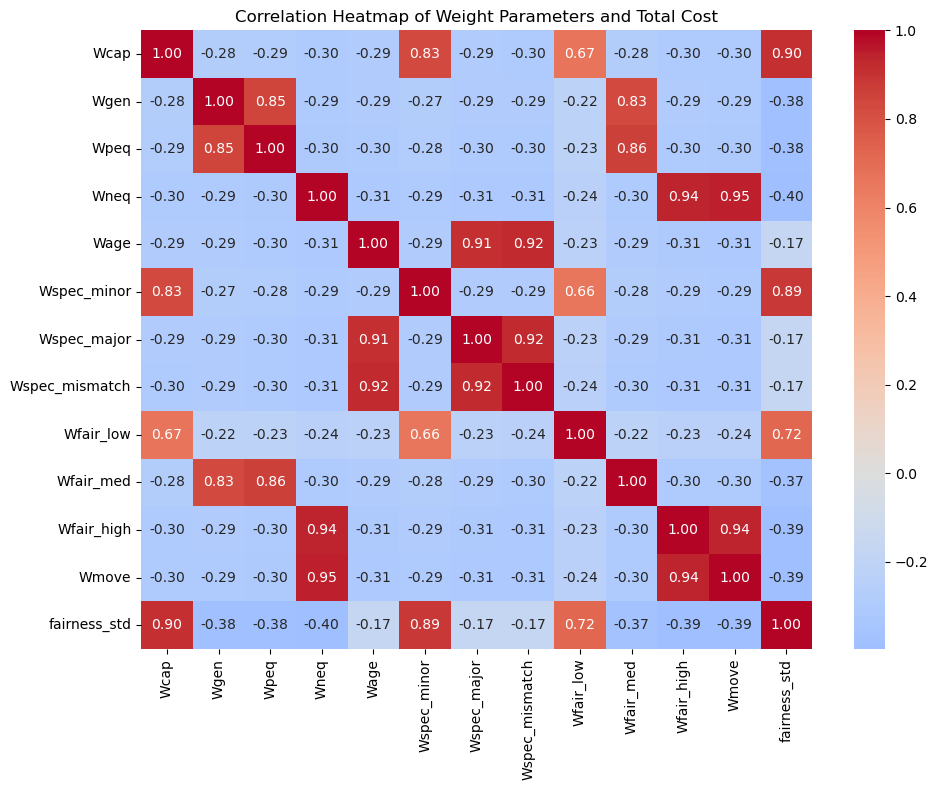

In [29]:
# Load the dataset from a CSV file into a pandas DataFrame.
df = pd.read_csv("rsm_all_experiments.csv")

# Define a list of column names representing weight parameters.
weight_columns = [
    'Wcap', 'Wgen', 'Wpeq', 'Wneq', 'Wage',
    'Wspec_minor', 'Wspec_major', 'Wspec_mismatch',
    'Wfair_low', 'Wfair_med', 'Wfair_high', 'Wmove'
]
# Define the name of the target column for analysis.
target_column = 'fairness_std'

# Create a new DataFrame containing only the weight columns and the target column.
df_selected = df[weight_columns + [target_column]]

# Compute the pairwise correlation between all selected columns.
corr = df_selected.corr()

# Create a figure and axes for the heatmap plot.
plt.figure(figsize=(10, 8))
# Generate a heatmap to visualize the correlation matrix.
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
# Set the title of the heatmap plot.
plt.title("Correlation Heatmap of Weight Parameters and Total Cost")
# Adjust layout to prevent labels overlapping.
plt.tight_layout()
# Save the generated plot to a file in PNG format with a resolution of 300 dpi.
plt.savefig("correlation_heatmap_weights_total_cost.png", dpi=300)  # Save the plot
# Display the plot.
plt.show()

In [67]:
# 1. Load data
df = pd.read_csv("rsm_all_experiments.csv") # Load data from the CSV file into a DataFrame
df = df[df['status'] == 'feasible'] # Filter the DataFrame to include only rows where 'status' is 'feasible'

# 2. Define weights/features
weight_cols = [ # Define a list of column names that represent the weights or features
    'Wcap', 'Wgen', 'Wpeq', 'Wneq', 'Wage',
    'Wspec_minor', 'Wspec_major', 'Wspec_mismatch',
    'Wfair_low', 'Wfair_med', 'Wfair_high', 'Wmove'
]
X = df[weight_cols] # Create a DataFrame X with only the weight columns
y = df['fairness_std'] # Create a Series y with the target variable 'fairness_std'

# 3. Fit Linear Regression
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42 # 80% for training, 20% for testing, with a fixed random state for reproducibility
)
model = LinearRegression() # Initialize the Linear Regression model
model.fit(X_train, y_train) # Train the model using the training data

# Predictions
y_train_pred = model.predict(X_train) # Make predictions on the training data
y_test_pred = model.predict(X_test) # Make predictions on the testing data

# Adjusted R² function
def adjusted_r2(r2, n, k): # Define a function to calculate adjusted R-squared
    return 1 - (1 - r2) * (n - 1) / (n - k - 1) # Formula for adjusted R-squared

# R² values
train_r2 = r2_score(y_train, y_train_pred) # Calculate the R-squared for the training data
test_r2 = r2_score(y_test, y_test_pred) # Calculate the R-squared for the testing data
adj_r2 = adjusted_r2(train_r2, X_train.shape[0], X_train.shape[1]) # Calculate the adjusted R-squared for the training data

# 4. Print model summary
print("\n=== Linear Regression Summary ===") # Print a header for the summary
print(f"Intercept: {model.intercept_:.4f}") # Print the intercept of the linear model
print("\nCoefficients:") # Print a header for the coefficients
for name, coef in zip(weight_cols, model.coef_): # Iterate through weight columns and their corresponding coefficients
    print(f"{name:15s}: {coef:.4f}") # Print each weight column name and its coefficient

print("\nModel Performance:") # Print a header for model performance metrics
print(f"Train R²:         {train_r2:.4f}") # Print the training R-squared
print(f"Adjusted R²:      {adj_r2:.4f}") # Print the adjusted R-squared
print(f"Test R²:          {test_r2:.4f}") # Print the testing R-squared
print(f"Train MSE:        {mean_squared_error(y_train, y_train_pred):.4f}") # Print the Mean Squared Error for the training data
print(f"Test MSE:         {mean_squared_error(y_test, y_test_pred):.4f}") # Print the Mean Squared Error for the testing data

# 5. Optimization: Find weights that minimize predicted fairness_std
def predict_fairness(weights): # Define a function to predict fairness_std based on given weights
    weights_df = pd.DataFrame([weights], columns=weight_cols) # Create a DataFrame from the input weights
    pred = model.predict(weights_df)[0] # Predict the fairness_std using the trained model
    return max(pred, 0.0)  # Ensure non-negative prediction # Return the prediction, ensuring it's not negative

def objective(w): # Define the objective function to be minimized (the predicted fairness_std)
    return predict_fairness(w) # Return the predicted fairness_std

# Optimization setup
bounds = [(0, 15) for _ in weight_cols] # Define the bounds for each weight (between 0 and 15)
initial_weights = np.ones(len(weight_cols)) # Define the initial guess for the weights (all ones)

# Run optimization
# Use the minimize function to find the weights that minimize the objective function
result = minimize(objective, initial_weights, bounds=bounds)
optimal_weights = result.x # Extract the optimal weights from the optimization result
min_fairness_std = result.fun # Extract the minimum predicted fairness_std from the optimization result

# 6. Output optimal weights
print("\n=== Optimized Weights to Minimize Predicted Fairness Std ===") # Print a header for the optimal weights
for name, val in zip(weight_cols, optimal_weights): # Iterate through weight column names and their optimal values
    print(f"{name:15s}: {val:.4f}") # Print each weight column name and its optimal value
print(f"\nPredicted minimum fairness_std: {min_fairness_std:.4f}") # Print the predicted minimum fairness_std


=== Linear Regression Summary ===
Intercept: 43.8104

Coefficients:
Wcap           : 6.0830
Wgen           : -4.3390
Wpeq           : -3.3550
Wneq           : -1.9112
Wage           : -0.9215
Wspec_minor    : 8.8170
Wspec_major    : -1.1710
Wspec_mismatch : -2.3407
Wfair_low      : 3.1906
Wfair_med      : -2.3734
Wfair_high     : -1.7371
Wmove          : -1.5216

Model Performance:
Train R²:         0.9603
Adjusted R²:      0.9538
Test R²:          0.9047
Train MSE:        51.2325
Test MSE:         99.4734

=== Optimized Weights to Minimize Predicted Fairness Std ===
Wcap           : 0.0000
Wgen           : 5.3390
Wpeq           : 4.3550
Wneq           : 2.9112
Wage           : 1.9215
Wspec_minor    : 0.0000
Wspec_major    : 2.1710
Wspec_mismatch : 3.3407
Wfair_low      : 0.0000
Wfair_med      : 3.3734
Wfair_high     : 2.7371
Wmove          : 2.5216

Predicted minimum fairness_std: 0.0000


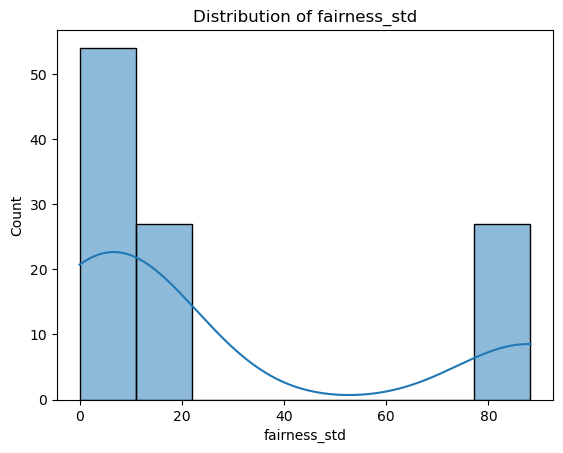

In [41]:
# Create a histogram with a kernel density estimate (KDE) plot
sns.histplot(df['fairness_std'], kde=True)
# Set the title of the plot
plt.title("Distribution of fairness_std")
# Display the plot
plt.show()

In [69]:
# Log Transformed Model
# 1. Load data
df = pd.read_csv("rsm_all_experiments.csv") # Load the dataset from the CSV file
df = df[df['status'] == 'feasible'] # Filter the DataFrame to include only 'feasible' experiments

# 2. Define weights/features
weight_cols = [ # Define the list of columns representing the weights (features)
    'Wcap', 'Wgen', 'Wpeq', 'Wneq', 'Wage',
    'Wspec_minor', 'Wspec_major', 'Wspec_mismatch',
    'Wfair_low', 'Wfair_med', 'Wfair_high', 'Wmove'
]
X = df[weight_cols] # Create the feature DataFrame X using the weight columns

# === Target: Log-transformed fairness_std
# Remove top 5% of fairness_std
threshold = df['fairness_std'].quantile(0.95) # Calculate the 95th percentile of 'fairness_std'
df_filtered = df[df['fairness_std'] <= threshold].copy() # Create a filtered DataFrame excluding the top 5%

# Apply log transformation (log1p) to the filtered 'fairness_std' and store in a new column
df_filtered['fairness_std_log'] = np.log1p(df_filtered['fairness_std'])


# 3. Train/test split
# Split the filtered data into training and testing sets for features (X) and target (y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train) # Train the model using the training data (X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Adjusted R²
def adjusted_r2(r2, n, k):  # Define a function to calculate the adjusted R-squared
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
adj_r2 = adjusted_r2(train_r2, X_train.shape[0], X_train.shape[1])

# 5. Print model summary
print("\n=== Linear Regression Summary (log-transformed target) ===")
print(f"Intercept: {model.intercept_:.4f}")
print("\nCoefficients:")
for name, coef in zip(weight_cols, model.coef_):
    print(f"{name:15s}: {coef:.4f}")

print("\nModel Performance (log scale):")
print(f"Train R²:         {train_r2:.4f}")
print(f"Adjusted R²:      {adj_r2:.4f}")
print(f"Test R²:          {test_r2:.4f}")
print(f"Train MSE:        {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Test MSE:         {mean_squared_error(y_test, y_test_pred):.4f}")

# 6. Optimization: Find weights that minimize predicted fairness_std
def predict_fairness(weights):
    weights_df = pd.DataFrame([weights], columns=weight_cols)
    pred_log = model.predict(weights_df)[0]
    pred = np.expm1(pred_log)  # Convert back from log scale
    return max(pred, 0.0)  # Ensure non-negative prediction

def objective(w):
    return predict_fairness(w)

# Bounds and initial guess
bounds = [(0, 15) for _ in weight_cols]
initial_weights = np.ones(len(weight_cols))

# Run optimization
result = minimize(objective, initial_weights, bounds=bounds)
optimal_weights = result.x
min_fairness_std = result.fun

# 7. Output optimal weights
print("\n=== Optimized Weights to Minimize Predicted Fairness Std ===")
for name, val in zip(weight_cols, optimal_weights):
    print(f"{name:15s}: {val:.4f}")
print(f"\nPredicted minimum fairness_std (back-transformed): {min_fairness_std:.4f}")



=== Linear Regression Summary (log-transformed target) ===
Intercept: 43.8104

Coefficients:
Wcap           : 6.0830
Wgen           : -4.3390
Wpeq           : -3.3550
Wneq           : -1.9112
Wage           : -0.9215
Wspec_minor    : 8.8170
Wspec_major    : -1.1710
Wspec_mismatch : -2.3407
Wfair_low      : 3.1906
Wfair_med      : -2.3734
Wfair_high     : -1.7371
Wmove          : -1.5216

Model Performance (log scale):
Train R²:         0.9603
Adjusted R²:      0.9538
Test R²:          0.9047
Train MSE:        51.2325
Test MSE:         99.4734

=== Optimized Weights to Minimize Predicted Fairness Std ===
Wcap           : 0.0000
Wgen           : 15.0000
Wpeq           : 15.0000
Wneq           : 15.0000
Wage           : 15.0000
Wspec_minor    : 0.0000
Wspec_major    : 15.0000
Wspec_mismatch : 15.0000
Wfair_low      : 0.0000
Wfair_med      : 15.0000
Wfair_high     : 15.0000
Wmove          : 15.0000

Predicted minimum fairness_std (back-transformed): 0.0000


In [71]:
# Define a function to calculate the compatibility penalty between a person and a room.
def compatibility_penalty(p, r, department_age_limits=None):
    pen = 0 # Initialize the penalty to 0

    # Wcap: Preferred room capacity (weight = 0.0000, ignored)
    # Check if room capacity exceeds preferred capacity (this penalty is currently ignored as per weight)
    if r.capacity > p.prefered_capacity:
        pen += 0.0 # Add 0 to penalty

    # Wgen: Gender mismatch — 10.7655
    # Check for gender mismatch between the room and the person
    if r.gender in ['F', 'M'] and r.gender != p.gender:
        pen += 10.7655 # Add penalty for gender mismatch

    # Wpeq: Preferred equipment unmet — 3.0312
    # Check if any preferred equipment of the person is not available in the room
    equip_len = min(len(p.prefers), len(r.has)) # Determine the minimum length of preferred and available equipment lists
    if any(p.prefers[i] == 1 and r.has[i] == 0 for i in range(equip_len)):
        pen += 3.0312 # Add penalty if preferred equipment is unmet

    # Wneq: Needed equipment unmet — 4.0915
    # Check if any needed equipment of the person is not available in the room
    need_len = min(len(p.needs), len(r.has)) # Determine the minimum length of needed and available equipment lists
    if any(p.needs[i] == 1 and r.has[i] == 0 for i in range(need_len)):
        pen += 4.0915 # Add penalty if needed equipment is unmet

    # Wage: Department age limits — 1.0249
    # Check if the person's age is outside the department's age limits
    if department_age_limits: # Check if department age limits are provided
        min_age, max_age = department_age_limits.get(r.department, (0, 0)) # Get age limits for the room's department
        if (min_age and p.age < min_age) or (max_age and p.age > max_age): # Check if age is below min or above max
            pen += 1.0249 # Add penalty for age limit violation

    # Wspec_minor: 0.0000 (ignored)
    # Wspec_major: 1.0316
    # Wspec_mismatch: 1.0632

    # Specialism 1
    # Check penalties related to the person's first specialism
    if p.specialism_id1 is not None: # Check if the first specialism is specified
        if p.specialism_id1 in r.spec_ids: # Check if the specialism is in the room's specialism IDs
            idx = r.spec_ids.index(p.specialism_id1) # Get the index of the specialism in the room's list
            penalty_level = r.penalties[idx] # Get the penalty level associated with this specialism in the room
            if penalty_level == 2:
                pen += 0.0  # Wspec_minor (penalty is 0 for minor level)
            elif penalty_level >= 3:
                pen += 1.0316  # Wspec_major (add penalty for major level or higher)
        else:
            pen += 1.0632  # Wspec_mismatch (add penalty if the specialism is not in the room's list)

    # Specialism 2
    # Check penalties related to the person's second specialism
    if p.specialism_id2 is not None: # Check if the second specialism is specified
        if p.specialism_id2 in r.spec_ids: # Check if the specialism is in the room's specialism IDs
            idx = r.spec_ids.index(p.specialism_id2) # Get the index of the specialism in the room's list
            penalty_level = r.penalties[idx] # Get the penalty level associated with this specialism in the room
            if penalty_level == 2:
                pen += 0.0  # Wspec_minor (penalty is 0 for minor level)
            elif penalty_level >= 3:
                pen += 1.0316  # Wspec_major (add penalty for major level or higher)
        else:
            pen += 1.0632  # Wspec_mismatch (add penalty if the specialism is not in the room's list)

    return pen # Return the total calculated penalty

Solving day 0...
Day 0 (initial) thresholds - Low: 4.06, High: 8.19
Day 0 solved in 0.38s — OPTIMAL
Solving day 1...
Day 1 thresholds - Low: 4.06, High: 8.19
Day 1 solved in 0.74s — OPTIMAL
Solving day 2...
Day 2 thresholds - Low: 3.03, High: 8.19
Day 2 solved in 1.23s — OPTIMAL
Solving day 3...
Day 3 thresholds - Low: 3.81, High: 8.19
Day 3 solved in 2.73s — OPTIMAL
Solving day 4...
Day 4 thresholds - Low: 4.09, High: 8.58
Day 4 solved in 3.93s — OPTIMAL
Solving day 5...
Day 5 thresholds - Low: 4.56, High: 10.72
Day 5 solved in 4.49s — OPTIMAL
Solving day 6...
Day 6 thresholds - Low: 4.36, High: 10.77
Day 6 solved in 4.19s — OPTIMAL
Solving day 7...
Day 7 thresholds - Low: 4.18, High: 10.77
Day 7 solved in 5.69s — OPTIMAL
Solving day 8...
Day 8 thresholds - Low: 4.41, High: 10.77
Day 8 solved in 5.89s — OPTIMAL
Solving day 9...
Day 9 thresholds - Low: 4.87, High: 10.77
Day 9 solved in 6.91s — OPTIMAL
Solving day 10...
Day 10 thresholds - Low: 5.15, High: 10.77
Day 10 solved in 5.35s —

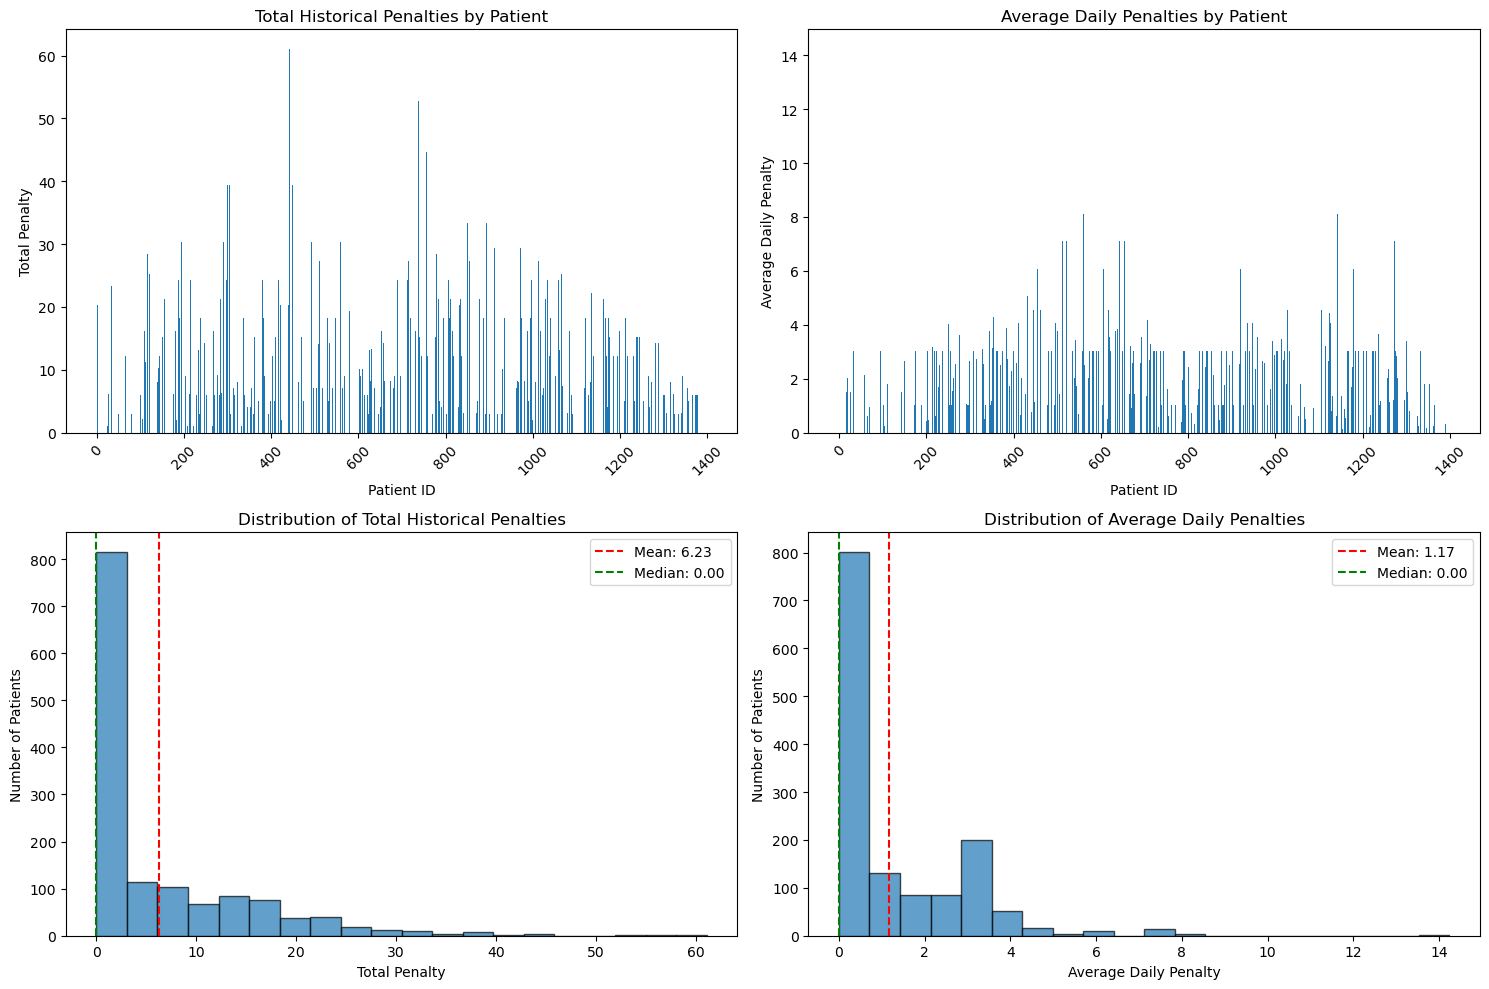

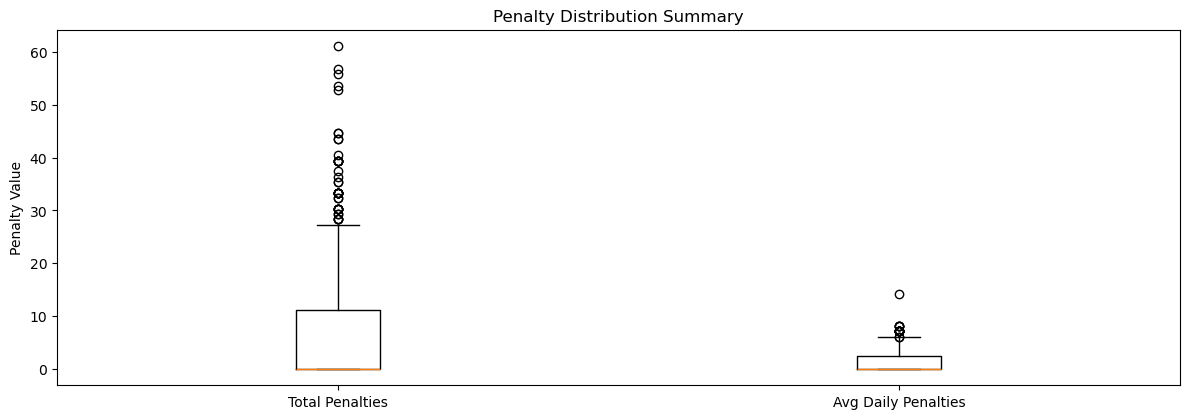

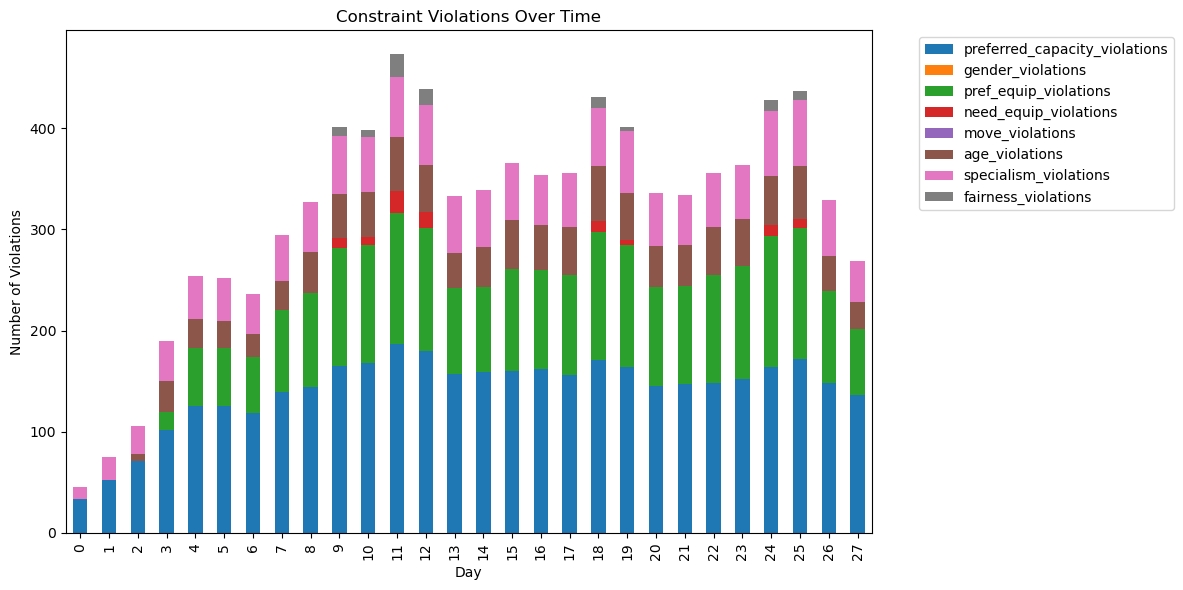

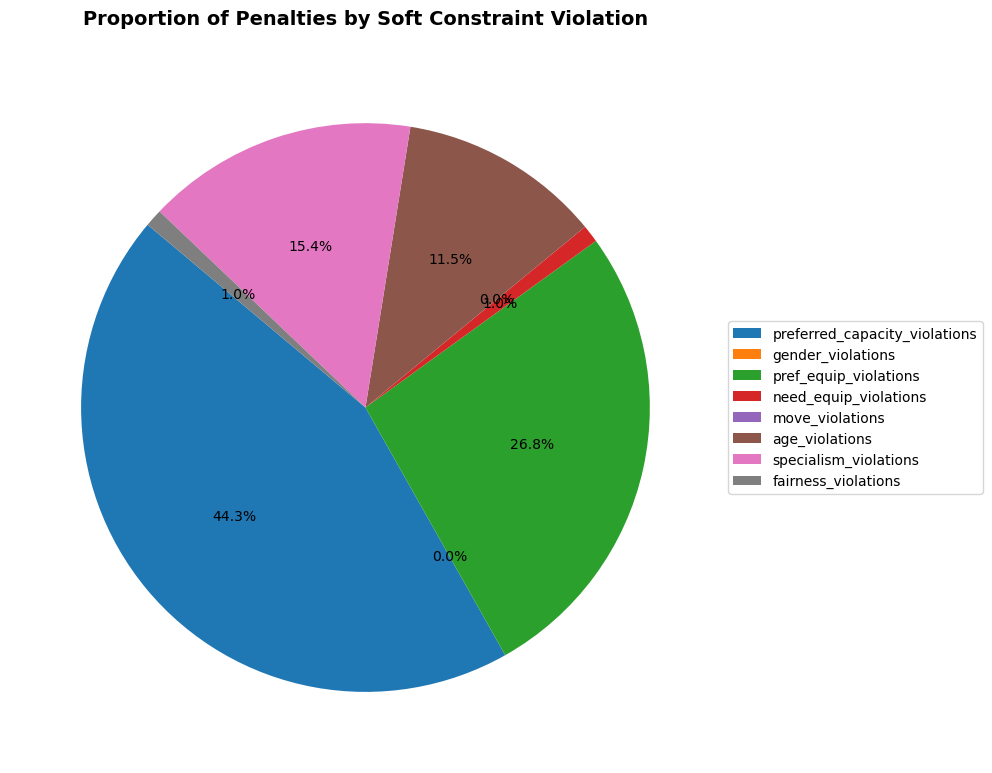

In [89]:
# --- Main function to solve the hospital allocation problem ---
def solve_hospital_allocation():
    # Build hospital data (rooms and patients)
    rooms, patients = build_hospital_data()
    # Set a random seed for reproducibility of simulated schedule changes
    random.seed(42)
    # Parse department age limits from the specified file
    department_age_limits = parse_department_ages("test9.txt")

    # --- Metrics bookkeeping ---
    total_duration = 0.0 # Initialize total solving duration
    # Initialize historical penalties for each patient to zero
    historical_penalties = {p.id: 0 for p in patients}
    previous_assignments = {} # Dictionary to store the previous room assignment for each patient
    daily_assignment_penalties = {} # Dictionary to store penalties for assignments on each day (not fully used in this version)

    # 1) Horizon: days 0 … last admission day
    # Determine the last admission day among all patients
    last_admission_day = max(p.admission_day for p in patients)
    # Create a range of all days from 0 to the last admission day
    all_days = range(last_admission_day + 1)
    logs = {} # Dictionary to store logs (not fully used in this version)
    all_assignments = {} # Dictionary to store assignments and violation scores for each day
    results = [] # List to store summary results for each day

    # Solve day by day to allow threshold recalculation
    for current_day in all_days:
        print(f"Solving day {current_day}...")
        objective_vals = [] # List to store objective values (not fully used in this version)
        time_stamps = [] # List to store timestamps (not fully used in this version)
        # Get penalties from the previous day's assignment (not fully used in this version)
        prev_penalties = daily_assignment_penalties.get(current_day - 1, {})
        # Get the maximum penalty from the previous day (not fully used in this version)
        max_prev_penalty = max(prev_penalties.values(), default=None)

        # --- Simulate possible patient schedule changes ON THIS DAY ---
        for p in patients:

            # Delay admission (only if admission is today)
            if p.admission_day == current_day:
                if random.random() < 0.3: # 30% chance of delay
                    delay = random.randint(1, 2) # Delay by 1 or 2 days
                    duration = p.release_day - p.admission_day # Calculate current stay duration
                    p.admission_day += delay # Update admission day
                    p.release_day = p.admission_day + duration # Update release day based on new admission day and original duration

                    # Record the arrival delay
                    if not hasattr(p, "arrival_delays"):
                        p.arrival_delays = []
                    p.arrival_delays.append({
                        "day": current_day,
                        "delay": delay,
                        "new_admission": p.admission_day,
                        "new_release": p.release_day,
                    })

            # Early admission (only if admission is today)
            # This part seems redundant as it's the same condition as Delay admission
            # The logic for early admission should be separated or handled differently.
            if p.admission_day == current_day:
                if random.random() < 0.3: # 30% chance of early admission
                    advance = random.randint(1, 2) # Advance by 1 or 2 days
                    duration = p.release_day - p.admission_day # Calculate current stay duration
                    p.admission_day = max(0, p.admission_day - advance) # Update admission day, ensuring it's not before day 0
                    p.release_day = p.admission_day + duration # Update release day based on new admission day and original duration

                    # Record the early arrival
                    if not hasattr(p, "early_arrivals"):
                        p.early_arrivals = []
                    p.early_arrivals.append({
                        "day": current_day,
                        "advance": advance,
                        "new_admission": p.admission_day,
                        "new_release": p.release_day,
                    })

            # Late release (only if release is today)
            if p.release_day == current_day:
                if random.random() < 0.3: # 30% chance of late release
                    extension = random.randint(1, 2) # Extend by 1 or 2 days
                    p.release_day += extension # Update release day

                    # Record the late release
                    if not hasattr(p, "late_releases"):
                        p.late_releases = []
                    p.late_releases.append({
                        "day": current_day,
                        "extension": extension,
                        "new_release": p.release_day,
                    })

            # Early release (only if release is today)
            if p.release_day == current_day:
                if random.random() < 0.3: # 30% chance of early release
                    reduction = random.randint(1, 2) # Reduce by 1 or 2 days
                    # Calculate the new release day, ensuring it's at least one day after admission
                    new_release = max(p.admission_day + 1, p.release_day - reduction)
                    # Check if the release day was actually reduced
                    if new_release < p.release_day:
                        # Record the early release
                        if not hasattr(p, "early_releases"):
                            p.early_releases = []
                        p.early_releases.append({
                            "day": current_day,
                            "early_by": p.release_day - new_release, # Amount of early release
                            "new_release": new_release, # The new release day
                        })
                        p.release_day = new_release # Update the release day

        # Identify patients who are present in the hospital on the current day
        present_patients = [p for p in patients if p.admission_day <= current_day < p.release_day]
        # If there are no patients present, skip to the next day
        if not present_patients:
            continue

        # --- Threshold calculation for fairness penalties ---
        if current_day > 0:
            # Calculate fairness scores for all possible patient-room assignments for present patients on this day
            all_fairness_scores = []
            for p in present_patients:
                for r in rooms:
                    base_pen = compatibility_penalty(p, r) # Get the base compatibility penalty
                    # Calculate bias based on historical penalties, normalized by the number of days passed + 1
                    bias = 1 + historical_penalties[p.id] / max(1, current_day + 1)
                    fairness_score = base_pen * bias # Calculate the fairness score with historical bias
                    all_fairness_scores.append(fairness_score)

            # Convert scores to a numpy array for percentile calculation
            scores_array = np.array(all_fairness_scores)
            # Calculate the lower and upper fairness thresholds based on percentiles
            threshold_low = np.percentile(scores_array, 33) # 33rd percentile
            threshold_high = np.percentile(scores_array, 67) # 67th percentile

            print(f"Day {current_day} thresholds - Low: {threshold_low:.2f}, High: {threshold_high:.2f}")
        else: # For the first day (current_day == 0)
            # Calculate only base compatibility scores as there's no historical data yet
            all_base_scores = []
            for p in present_patients:
                for r in rooms:
                    base_pen = compatibility_penalty(p, r) # Get the base compatibility penalty
                    all_base_scores.append(base_pen)

            # Convert scores to a numpy array for percentile calculation
            scores_array = np.array(all_base_scores)
            # Calculate the lower and upper thresholds based on percentiles of base scores
            threshold_low = np.percentile(scores_array, 33)
            threshold_high = np.percentile(scores_array, 67)

            print(f"Day {current_day} (initial) thresholds - Low: {threshold_low:.2f}, High: {threshold_high:.2f}")

        # --- OR-Tools CP-SAT Model Definition ---
        model = cp_model.CpModel() # Create a new CP-SAT model
        seats = {} # Dictionary to hold the boolean variables for patient-room assignments
        # Create a boolean variable for each possible assignment of a present patient to a room on the current day
        for r in rooms:
            for p in present_patients:
                seats[(r.id, p.id)] = model.NewBoolVar(f"s_r{r.id}_p{p.id}_d{current_day}")

        # --- Constraints ---
        # Constraint: Each present patient must be assigned to exactly one room
        for p in present_patients:
            model.Add(sum(seats[(r.id, p.id)] for r in rooms) == 1)

        # Constraint: Each room's capacity must not be exceeded
        for r in rooms:
            model.Add(sum(seats[(r.id, p.id)] for p in present_patients) <= r.capacity)

        # Determine the number of equipment types to consider based on minimum of max in rooms and patients
        num_equipment_types = min(
            max(len(r.has) for r in rooms), # Maximum number of equipment types a room can have
            max(len(p.needs) for p in present_patients) # Maximum number of equipment types a patient can need
        )

        # Hard Constraint: Patients needing specific equipment must be assigned to rooms with that equipment
        # This constraint is only enforced if the total available equipment of a type is greater than or equal to the total needed by patients.
        for i in range(num_equipment_types):
            # Find rooms that have the current equipment type
            rooms_with_equipment = [r for r in rooms if len(r.has) > i and r.has[i] == 1]
            total_available = len(rooms_with_equipment) # Count rooms with the equipment

            # Find patients who need the current equipment type
            patients_with_need = [p for p in present_patients if len(p.needs) > i and p.needs[i] == 1]
            total_needed = len(patients_with_need) # Count patients who need the equipment

            # Only enforce the hard constraint if availability is sufficient for the demand
            if total_available >= len(patients_with_need):
                for p in patients_with_need:
                    # Get the boolean variables for assignments of this patient to rooms with the equipment
                    assign_with_eq = [seats[(r.id, p.id)] for r in rooms_with_equipment]
                    # Add a constraint that at least one of these assignments must be true (patient must be in a room with the needed equipment)
                    model.AddBoolOr(assign_with_eq)

        # --- Soft Constraints (Violations) ---
        # Lists to store the boolean variables that represent violations of soft constraints
        viol_pref_cap = [] # Preferred capacity violations
        viol_gender = [] # Gender violations
        viol_pref_eq = [] # Preferred equipment violations
        viol_need_eq = [] # Needed equipment violations
        viol_age = [] # Age limit violations
        viol_spec_minor = [] # Minor specialism violations
        viol_spec_major = [] # Major specialism violations
        viol_spec_mismatch = [] # Specialism mismatch violations
        viol_fairness_low = [] # Fairness violations below low threshold (used for penalties if weighted)
        viol_fairness_medium = [] # Fairness violations between low and high thresholds (used for penalties if weighted)
        viol_fairness_high = [] # Fairness violations above high threshold
        move_penalties = [] # Penalties for moving a patient to a different room than the previous day

        # Iterate through each patient and room to identify potential violations for each assignment
        for p in present_patients:
            prev_room = previous_assignments.get(p.id) # Get the room the patient was assigned to on the previous day
            for r in rooms:
                s = seats[(r.id, p.id)] # Get the boolean variable for assigning patient p to room r

                # Check for preferred capacity violation
                if r.capacity > p.prefered_capacity:
                    viol_pref_cap.append(s) # Add the assignment variable to the violation list

                # Check for gender violation
                if r.gender in ('M','F') and r.gender != p.gender:
                    viol_gender.append(s) # Add the assignment variable to the violation list

                # Check for preferred equipment violation
                # Use min length to avoid IndexError if equipment lists have different lengths
                equip_len = min(len(p.prefers), len(r.has))
                # Check if any preferred equipment is missing in the room
                if any(p.prefers[i] == 1 and r.has[i] == 0 for i in range(equip_len)):
                    viol_pref_eq.append(s) # Add the assignment variable to the violation list

                # Check for needed equipment violation
                equip_need_len = min(len(p.needs), len(r.has))
                # Check if any needed equipment is missing in the room
                if any(p.needs[i] == 1 and r.has[i] == 0 for i in range(equip_need_len)):
                    viol_need_eq.append(s) # Add the assignment variable to the violation list

                # --- Generalized Age Constraint ---
                # Get the age limits for the room's department
                min_age, max_age = department_age_limits.get(r.department, (0, 0))
                # Check if the patient's age violates the department's age limits
                if (min_age and p.age < min_age) or (max_age and p.age > max_age):
                    viol_age.append(s) # Add the assignment variable to the violation list

                # --- Specialism 1 Violations ---
                if p.specialism_id1 in r.spec_ids: # Check if the patient's first specialism is in the room's specialisms
                    idx = r.spec_ids.index(p.specialism_id1) # Get the index
                    pen = r.penalties[idx] # Get the associated penalty level
                    if pen == 2: # Minor penalty level
                        viol_spec_minor.append(s) # Add to minor violation list
                    elif pen >= 3: # Major penalty level or higher
                        viol_spec_major.append(s) # Add to major violation list
                else:
                    viol_spec_mismatch.append(s) # Add to mismatch violation list if specialism not in room's list

                # --- Specialism 2 Violations ---
                if p.specialism_id2 is not None: # Check if the patient has a second specialism
                    if p.specialism_id2 in r.spec_ids: # Check if the patient's second specialism is in the room's specialisms
                        idx = r.spec_ids.index(p.specialism_id2) # Get the index
                        pen = r.penalties[idx] # Get the associated penalty level
                        if pen == 2: # Minor penalty level
                            viol_spec_minor.append(s) # Add to minor violation list
                        elif pen >= 3: # Major penalty level or higher
                            viol_spec_major.append(s) # Add to major violation list
                    else:
                        viol_spec_mismatch.append(s) # Add to mismatch violation list if specialism not in room's list

                # --- Fairness Violations ---
                base_pen = compatibility_penalty(p, r) # Get the base compatibility penalty
                if current_day > 0: # For days after the first day
                    # Calculate bias based on historical penalties, normalized by the number of days passed + 1
                    bias = 1 + historical_penalties[p.id] / max(1, current_day + 1)
                    fairness_score = base_pen * bias # Calculate fairness score with historical bias
                else: # For the first day
                    fairness_score = base_pen # Fairness score is just the base penalty

                # Check if the fairness score exceeds the calculated thresholds
                if fairness_score > threshold_high:
                    viol_fairness_high.append(s) # Add to high fairness violation list
                elif fairness_score > threshold_low:
                    viol_fairness_medium.append(s) # Add to medium fairness violation list
                elif fairness_score < threshold_low:
                     # This condition seems to be for penalizing scores below the low threshold,
                     # which might be counter-intuitive for minimizing penalties.
                     # Based on the weight Wfair_low = 0, this penalty is effectively ignored.
                    viol_fairness_low.append(s) # Add to low fairness violation list

                # --- Move Penalty ---
                # Check if the patient was assigned to a different room on the previous day
                if prev_room is not None and r.id != prev_room:
                    move_penalties.append(s) # Add the assignment variable to the move penalty list

        # --- Objective Function ---
        # Total number of possible patient-seat pairs for normalization
        normalizer = len(present_patients) * len(rooms)

        # Safe normalization function for OR-Tools sum expressions
        def normalized_sum(viol_list):
            # Returns a linear expression representing the sum of violations, scaled by the normalizer.
            # Ensures the normalizer is not zero to avoid division by zero.
            return sum(viol_list) * (1.0 / max(1, normalizer)) # Use max(1, normalizer) to prevent division by zero

        # Weights for each soft constraint violation type
        # These weights are derived from the RSM optimization (likely from a previous step)
        Wcap, Wgen, Wpeq, Wneq, Wage = 0, 10.7655, 3.0312, 4.0915, 1.0249
        Wspec_minor, Wspec_major, Wspec_mismatch = 0, 1.0316, 1.0632
        Wfair_low, Wfair_med, Wfair_high = 0, 0, 2.1260
        Wmove = 0.6097

        # Minimize the scaled and weighted sum of all soft constraint violations
        model.Minimize(
              Wcap * normalized_sum(viol_pref_cap) # Weighted sum of preferred capacity violations
            + Wgen * normalized_sum(viol_gender) # Weighted sum of gender violations
            + Wpeq * normalized_sum(viol_pref_eq) # Weighted sum of preferred equipment violations
            + Wneq * normalized_sum(viol_need_eq) # Weighted sum of needed equipment violations
            + Wage * normalized_sum(viol_age) # Weighted sum of age limit violations
            + Wspec_minor * normalized_sum(viol_spec_minor) # Weighted sum of minor specialism violations
            + Wspec_major * normalized_sum(viol_spec_major) # Weighted sum of major specialism violations
            + Wspec_mismatch * normalized_sum(viol_spec_mismatch) # Weighted sum of specialism mismatch violations
            + Wfair_low * normalized_sum(viol_fairness_low) # Weighted sum of low fairness violations (weight is 0)
            + Wfair_med * normalized_sum(viol_fairness_medium) # Weighted sum of medium fairness violations (weight is 0)
            + Wfair_high * normalized_sum(viol_fairness_high) # Weighted sum of high fairness violations
            + Wmove * normalized_sum(move_penalties) # Weighted sum of move penalties
        )

        # --- Solve the Model ---
        solver = cp_model.CpSolver() # Create a CP-SAT solver instance
        start = time.time() # Record the start time for solving
        status = solver.Solve(model) # Solve the CP-SAT model
        day_duration = time.time() - start # Calculate the time taken to solve for the current day
        total_duration += day_duration # Add the current day's duration to the total duration

        # Print the solving status and time for the current day
        print(f"Day {current_day} solved in {day_duration:.2f}s — {solver.StatusName(status)}")

        # --- Process Results if a feasible or optimal solution is found ---
        if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
            assign = {} # Dictionary to store the room assignment for each patient on this day
            violation_scores = [] # List to store detailed violation scores for each assigned patient
            daily_score = 0 # Initialize the total violation score for the day

            # Iterate through all present patients to find their assigned room and calculate penalties
            for p in present_patients:
                assigned_room = None # Initialize assigned room to None
                # Iterate through all rooms to find the one the patient was assigned to in the solution
                for r in rooms:
                    if solver.Value(seats[(r.id, p.id)]): # Check if the boolean variable for this assignment is true in the solution
                        assigned_room = r # Set the assigned room
                        assign[p.id] = r.id # Record the room ID in the assignments dictionary
                        previous_assignments[p.id] = r.id # Update the previous assignment for this patient for the next day
                        break # Found the assigned room, break the inner loop

                # If a room was assigned to the patient
                if assigned_room:
                    # Calculate the total compatibility penalty for this assignment
                    pen = compatibility_penalty(p, assigned_room, department_age_limits) # Pass department_age_limits
                    daily_score += pen # Add the penalty to the total daily score
                    historical_penalties[p.id] += pen  # Update the historical penalty for the patient

                    # Example equipment labels (ensure this list matches the actual dataset's equipment columns and order)
                    # This list is used for potential detailed violation reporting, though not explicitly printed in the current summary.
                    equipment_labels = ['telemetry', 'oxygen', 'nitrogen', 'television']

                    # Determine the maximum equipment index to consider based on minimum length of lists
                    max_equipment_index = min(len(p.needs), len(assigned_room.has), len(equipment_labels))

                    # Find indices of needed equipment that is missing in the assigned room
                    missing_eq = [
                        i for i in range(max_equipment_index)
                        if p.needs[i] == 1 and assigned_room.has[i] == 0
                    ]

                    # Determine minimum lengths for preferred and needed equipment checks
                    equip_len = min(len(p.prefers), len(assigned_room.has))
                    need_len = min(len(p.needs), len(assigned_room.has))

                    # --- Specialism Violations (for reporting) ---
                    spec_minor = 0 # Counter for minor specialism violations
                    spec_major = 0 # Counter for major specialism violations
                    spec_mismatch = 0 # Counter for specialism mismatch violations

                    # Specialism 1 violations
                    if p.specialism_id1 is not None: # Check if the patient has a first specialism
                        if p.specialism_id1 in assigned_room.spec_ids: # Check if the specialism is in the assigned room's list
                            idx = assigned_room.spec_ids.index(p.specialism_id1) # Get the index
                            spec_pen = assigned_room.penalties[idx] # Get the associated penalty level
                            if spec_pen == 2:
                                spec_minor += 1 # Increment minor violation count
                            elif spec_pen >= 3:
                                spec_major += 1 # Increment major violation count
                        else:
                            spec_mismatch += 1 # Increment mismatch violation count

                    # Specialism 2 violations
                    if p.specialism_id2 is not None: # Check if the patient has a second specialism
                        if p.specialism_id2 in assigned_room.spec_ids: # Check if the specialism is in the assigned room's list
                            idx = assigned_room.spec_ids.index(p.specialism_id2) # Get the index
                            spec_pen = assigned_room.penalties[idx] # Get the associated penalty level
                            if spec_pen == 2:
                                spec_minor += 1 # Increment minor violation count
                            elif spec_pen >= 3:
                                spec_major += 1 # Increment major violation count
                        else:
                            spec_mismatch += 1 # Increment mismatch violation count

                    # Append detailed violation scores for the current patient's assignment
                    violation_scores.append({
                        'patient_id': p.id,
                        'room_id': assigned_room.id,
                        'total_score': pen, # Total compatibility penalty for this assignment
                        'historical_penalty': historical_penalties[p.id], # Cumulative historical penalty for the patient
                        'violations': {
                            'capacity': int(assigned_room.capacity > p.prefered_capacity), # 1 if preferred capacity violated, 0 otherwise
                            'gender': int(assigned_room.gender in ['F', 'M'] and assigned_room.gender != p.gender), # 1 if gender mismatch, 0 otherwise
                            'equipment_pref': int(any(p.prefers[i] == 1 and assigned_room.has[i] == 0 for i in range(equip_len))), # 1 if any preferred equipment is missing, 0 otherwise
                            'equipment_need': int(any(p.needs[i] == 1 and assigned_room.has[i] == 0 for i in range(need_len))), # 1 if any needed equipment is missing, 0 otherwise
                            # Age violation check - Update this if using dynamic department age limits consistently
                            'age': int((assigned_room.department == 1 and p.age < 65) or (assigned_room.department == 4 and p.age > 16)), # 1 if age limit violated, 0 otherwise
                            'specialism_minor': spec_minor, # Count of minor specialism violations
                            'specialism_major': spec_major, # Count of major specialism violations
                            'specialism_mismatch': spec_mismatch, # Count of specialism mismatch violations
                            # Check for move violation: True if patient was assigned to a different room than the previous day
                            'moved': int(previous_assignments.get(p.id) is not None and assigned_room.id != previous_assignments.get(p.id))
                        }
                    })

            # Store the assignments and detailed violation scores for the current day
            all_assignments[current_day] = {
                'assignments': assign, # Dictionary of patient ID to room ID
                'violation_scores': violation_scores # List of detailed violation score dictionaries
            }

            # Count the number of move violations for the day (calculated based on the detailed violation scores)
            move_count = sum(v['violations']['moved'] for v in violation_scores)

            # This line seems redundant as it's the same as the block above.
            # It might overwrite the previous assignment data if not intended.
            all_assignments[current_day] = {
                'assignments': assign,
                'violation_scores': violation_scores
            }

            # Append summary results for the current day to the results list
            results.append({
                'day': current_day, # The current day
                'num_patients': len(present_patients), # Number of patients present on this day
                # Count total violations for each type across all assigned patients on this day
                'preferred_capacity_violations': sum(v['violations']['capacity'] for v in violation_scores),
                'gender_violations': sum(v['violations']['gender'] for v in violation_scores),
                'pref_equip_violations': sum(v['violations']['equipment_pref'] for v in violation_scores),
                'need_equip_violations': sum(v['violations']['equipment_need'] for v in violation_scores),
                'age_violations': sum(v['violations']['age'] for v in violation_scores),
                'specialism_violations': sum( # Sum of all specialism violation types
                    v['violations']['specialism_minor'] +
                    v['violations']['specialism_major'] +
                    v['violations']['specialism_mismatch']
                    for v in violation_scores
                ),
                'move_violations': sum(v['violations']['moved'] for v in violation_scores), # Total move violations
                # Count fairness violations (where total score exceeds the low threshold)
                'fairness_violations': sum(1 for v in violation_scores if v['total_score']  > threshold_low),
                'total_violation_score': daily_score, # Total compatibility penalty score for the day
                'threshold_low': threshold_low, # Low fairness threshold for the day
                'threshold_high': threshold_high # High fairness threshold for the day
            })

    # --- Final metrics and reporting after processing all days ---
    if results: # Check if there are any results (i.e., if any days had present patients)
        df = pd.DataFrame(results) # Create a pandas DataFrame from the daily results
        total_days = len(all_days) # Total number of days simulated
        # Calculate the success rate (days with feasible/optimal solution)
        success_rate = len(results) / total_days * 100
        # Get a list of all patient IDs
        patient_ids = list(historical_penalties.keys())
        # Calculate the length of stay for each patient
        stay_length = {p.id: max(1, p.release_day - p.admission_day) for p in patients}
        # Calculate the average daily penalty for each patient
        avg_daily_penalty = {pid: historical_penalties[pid]/stay_length[pid] for pid in stay_length}
        # Get a list of all average daily penalty values
        penalty_vals = list(avg_daily_penalty.values())

        # Calculate fairness metrics based on average daily penalties
        std_dev = np.std(penalty_vals) # Standard deviation
        gini = compute_gini(penalty_vals) # Gini coefficient
        jain = compute_jain(penalty_vals) # Jain's fairness index

        # Calculate the mean of the average daily penalties
        avg_penalties = [historical_penalties[pid]/stay_length[pid] for pid in patient_ids]
        # Find the indices of the patient with the maximum and minimum total historical penalty
        max_penalty_idx = np.argmax(penalty_vals)
        min_penalty_idx = np.argmin(penalty_vals)

        # Calculate the total number of fairness violations across all days
        total_fairness_penalties = df['fairness_violations'].sum()
        print(f"Total Fairness Penalties: {total_fairness_penalties}")

        # --- Build summary statistics table ---
        summary_stats = {
            "Metric": [
                "Total Solving Time (s)", # Total time taken to solve for all days
                "Success Rate (%)", # Percentage of days with a feasible or optimal solution
                "Fairness - StdDev of Daily Penalty", # Standard deviation of average daily penalties (fairness measure)
                "Fairness - Gini Coefficient", # Gini coefficient of average daily penalties (fairness measure)
                "Fairness - Jain Index", # Jain's fairness index of average daily penalties (fairness measure)
                "Total Penalty - Mean", # Mean of total historical penalties
                "Total Penalty - StdDev", # Standard deviation of total historical penalties
                "Total Penalty - Min", # Minimum total historical penalty
                "Total Penalty - Max", # Maximum total historical penalty
                "Avg Daily Penalty - Mean", # Mean of average daily penalties
                "Avg Daily Penalty - StdDev", # Standard deviation of average daily penalties
                "Avg Daily Penalty - Min", # Minimum average daily penalty
                "Avg Daily Penalty - Max", # Maximum average daily penalty
                "Patients with Zero Penalty", # Count of patients with a total historical penalty of 0
                "Patients with High Penalty (>mean+std)", # Count of patients with total historical penalty > mean + std dev
                f"Most Penalized Patient (ID {patient_ids[max_penalty_idx]})", # Details for the most penalized patient
                f"Least Penalized Patient (ID {patient_ids[min_penalty_idx]})", # Details for the least penalized patient
            ],
            "Value": [
                f"{total_duration:.2f}", # Formatted total duration
                f"{success_rate:.2f}", # Formatted success rate
                f"{std_dev:.2f}", # Formatted standard deviation
                f"{gini:.2f}", # Formatted Gini coefficient
                f"{jain:.2f}", # Formatted Jain index
                f"{np.mean(penalty_vals):.2f}", # Formatted mean total penalty
                f"{np.std(penalty_vals):.2f}", # Formatted standard deviation of total penalty
                f"{np.min(penalty_vals):.2f}", # Formatted minimum total penalty
                f"{np.max(penalty_vals):.2f}", # Formatted maximum total penalty
                f"{np.mean(avg_penalties):.2f}", # Formatted mean average daily penalty
                f"{np.std(avg_penalties):.2f}", # Formatted standard deviation of average daily penalty
                f"{np.min(avg_penalties):.2f}", # Formatted minimum average daily penalty
                f"{np.max(avg_penalties):.2f}", # Formatted maximum average daily penalty
                f"{sum(1 for p in penalty_vals if p == 0)}", # Count of patients with zero penalty
                f"{sum(1 for p in penalty_vals if p > np.mean(penalty_vals) + np.std(penalty_vals))}", # Count of highly penalized patients
                f"Total: {penalty_vals[max_penalty_idx]:.2f}, Avg: {avg_penalties[max_penalty_idx]:.2f}", # Formatted penalties for most penalized patient
                f"Total: {penalty_vals[min_penalty_idx]:.2f}, Avg: {avg_penalties[min_penalty_idx]:.2f}", # Formatted penalties for least penalized patient
            ]
        }

        # Create a DataFrame from the summary statistics
        summary_df = pd.DataFrame(summary_stats)

        # Print the summary statistics to the console
        print("\n=== SUMMARY STATISTICS ===")
        print(summary_df.to_string(index=False)) # Print without index

        # Save the summary statistics as a CSV file
        summary_df.to_csv("hospital_summary_statistics3.csv", index=False)

        # Save the summary statistics as a PNG image (as a table)
        fig, ax = plt.subplots(figsize=(12, len(summary_df) * 0.4)) # Create figure and axes
        ax.axis('off') # Turn off axes
        # Create a table plot
        table = ax.table(cellText=summary_df.values,
                         colLabels=summary_df.columns,
                         cellLoc='left', # Align cell text to the left
                         loc='center') # Center the table
        table.auto_set_font_size(False) # Prevent automatic font sizing
        table.set_fontsize(10) # Set font size
        table.scale(1, 1.2) # Scale the table
        plt.title("Hospital Allocation Summary Statistics", fontsize=14, weight='bold', pad=20) # Set plot title
        plt.tight_layout() # Adjust layout
        plt.savefig("hospital_summary_statistics3.png", dpi=300) # Save the figure as a PNG
        plt.close() # Close the figure

        # --- Plots for penalty analysis ---
        fig, axes = plt.subplots(2, 2, figsize=(15, 10)) # Create a figure and a 2x2 grid of subplots

        # 1. Bar plot of total historical penalties by patient
        penalty_vals = list(historical_penalties.values()) # Get total historical penalty values
        patient_ids = list(historical_penalties.keys()) # Get patient IDs

        axes[0,0].bar(range(len(patient_ids)), penalty_vals) # Create a bar plot
        axes[0,0].set_title('Total Historical Penalties by Patient') # Set title
        axes[0,0].set_xlabel('Patient ID') # Set x-label
        axes[0,0].set_ylabel('Total Penalty') # Set y-label
        axes[0,0].tick_params(axis='x', rotation=45) # Rotate x-axis labels

        # 2. Bar plot of average daily penalties by patient
        avg_penalties = [historical_penalties[pid]/stay_length[pid] for pid in patient_ids] # Calculate average daily penalties

        axes[0,1].bar(range(len(patient_ids)), avg_penalties) # Create a bar plot
        axes[0,1].set_title('Average Daily Penalties by Patient') # Set title
        axes[0,1].set_xlabel('Patient ID') # Set x-label
        axes[0,1].set_ylabel('Average Daily Penalty') # Set y-label
        axes[0,1].tick_params(axis='x', rotation=45) # Rotate x-axis labels

        # 3. Histogram of total penalties
        axes[1,0].hist(penalty_vals, bins=min(20, len(set(penalty_vals))), alpha=0.7, edgecolor='black') # Create a histogram
        axes[1,0].set_title('Distribution of Total Historical Penalties') # Set title
        axes[1,0].set_xlabel('Total Penalty') # Set x-label
        axes[1,0].set_ylabel('Number of Patients') # Set y-label
        axes[1,0].axvline(np.mean(penalty_vals), color='red', linestyle='--', label=f'Mean: {np.mean(penalty_vals):.2f}') # Add mean line
        axes[1,0].axvline(np.median(penalty_vals), color='green', linestyle='--', label=f'Median: {np.median(penalty_vals):.2f}') # Add median line
        axes[1,0].legend() # Add legend

        # 4. Histogram of average daily penalties
        axes[1,1].hist(avg_penalties, bins=min(20, len(set(avg_penalties))), alpha=0.7, edgecolor='black') # Create a histogram
        axes[1,1].set_title('Distribution of Average Daily Penalties') # Set title
        axes[1,1].set_xlabel('Average Daily Penalty') # Set x-label
        axes[1,1].set_ylabel('Number of Patients') # Set y-label
        axes[1,1].axvline(np.mean(avg_penalties), color='red', linestyle='--', label=f'Mean: {np.mean(avg_penalties):.2f}') # Add mean line
        axes[1,1].axvline(np.median(avg_penalties), color='green', linestyle='--', label=f'Median: {np.median(avg_penalties):.2f}') # Add median line
        axes[1,1].legend() # Add legend

        plt.tight_layout() # Adjust layout
        plt.savefig("penalty_subplots_summary3.png") # Save the figure
        plt.show() # Display the figure

        # --- Additional detailed penalty analysis plots ---
        plt.figure(figsize=(12, 8)) # Create a new figure

        # Box plot showing distribution of total and average daily penalties
        plt.subplot(2, 1, 1) # Create the first subplot in a 2x1 grid
        plt.boxplot([penalty_vals, avg_penalties], labels=['Total Penalties', 'Avg Daily Penalties']) # Create a box plot
        plt.title('Penalty Distribution Summary') # Set title
        plt.ylabel('Penalty Value') # Set y-label

        # This subplot seems intended for something else but is currently empty.
        # plt.subplot(2, 1, 2) # Create the second subplot

        plt.tight_layout() # Adjust layout
        plt.savefig("penalty_boxplot_summary3.png") # Save the figure
        plt.show() # Display the figure

        # --- Constraint Violations Over Time Plot ---
        # Define the columns representing different types of violations
        violation_cols = [
            'preferred_capacity_violations','gender_violations',
            'pref_equip_violations','need_equip_violations', 'move_violations',
            'age_violations','specialism_violations', 'fairness_violations'
        ]

        # Create a stacked bar plot showing the number of violations over time
        df.set_index('day')[violation_cols].plot.bar(stacked=True, figsize=(12,6))
        plt.title("Constraint Violations Over Time") # Set title
        plt.xlabel("Day") # Set x-label
        plt.ylabel("Number of Violations") # Set y-label
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot
        plt.tight_layout() # Adjust layout
        plt.savefig("constraint_violations_over_time3.png") # Save the figure
        plt.show() # Display the figure

        # --- Pie Chart of Total Constraint Violation Proportions ---
        # Sum the total violations for each type across all days
        violation_totals = df[violation_cols].sum()

        plt.figure(figsize=(10, 10)) # Create a new figure for the pie chart
        # Create a pie chart
        patches, texts, autotexts = plt.pie(
            violation_totals, # Data for the pie chart
            labels=None, # Do not display labels on the slices
            autopct='%1.1f%%', # Format percentage values to one decimal place
            startangle=140 # Start the first slice at 140 degrees
        )
        # Add a legend with violation types and their corresponding colors
        plt.legend(patches, violation_totals.index, loc="center left", bbox_to_anchor=(1, 0.5))
        plt.title("Proportion of Penalties by Soft Constraint Violation", fontsize=14, weight='bold', pad=20) # Set title
        plt.tight_layout() # Adjust layout
        plt.savefig("constraint_violation_pie_chart3.png", dpi=300) # Save the figure as PNG
        plt.show() # Display the figure

    # Return the collected data and results
    return all_assignments, rooms, patients, results

# --- Main execution block ---
if __name__ == "__main__":
    # Call the main allocation function to solve the problem and get results
    all_assignments, rooms, patients, results = solve_hospital_allocation()
    # Generate a detailed PDF report of the assignments
    generate_detailed_assignment_pdf(
        all_assignments,
        rooms,
        patients,
        benchmark_name="test9", # Name of the benchmark used
        filename="hospital_assignment_report3.pdf" # Name of the output PDF file
    )